## MICROSOFT RECOMMENDER, SAR ALGORITHM  

# Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scrapbook as sb
import matplotlib.pyplot as plt
import scipy, logging, sys, warnings, joblib
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import recommenders
from recommenders.models.sar import SAR 
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import (precision_at_k, mae, rsquared)

%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings('ignore')
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.4.4


# Define a list of top_k items that will be recommended to users

In [2]:
list_top_k=[10]#3,5,

# Load the data

In [3]:
data=pd.read_csv('ML_100K.csv', sep='\t')
data.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# check the shape of dataset
data.shape

(100000, 4)

In [5]:
# convert the ratings to float32 to reduce memory usage
data['rating'] = data['rating'].astype(np.float32)
data.head()

,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


# Split the data into train and test sets
	75% train set and 25% test set

In [6]:
train, test = python_stratified_split(data, 
                                      ratio=0.75,
                                      col_user='userID',
                                      col_item='itemID',
                                      seed=0)
#(train.shape, test.shape)

In [7]:
# Print the number of ratings, unique users, unique items
print(
f"""Train: 
Total Ratings: {len(train)}
Unique Users:  {len(train['userID'].unique())}
Unique Items:  {len(train['itemID'].unique())}
""")

print(
f"""Test: 
Total Ratings: {len(test)}
Unique Users:  {len(test['userID'].unique())}
Unique Items:  {len(test['itemID'].unique())}
""")

Train: 
Total Ratings: 74992
Unique Users:  943
Unique Items:  1644

Test: 
Total Ratings: 25008
Unique Users:  943
Unique Items:  1442



# Define the list of the similarities that will be investigated
similarity type must be one  of available similarity metrics:
	
	"cooccurrence", "jaccard", "lift", "HD_JACCARD", "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD", "MCCONNAUGHEY", "KULCZYNSKI_II", "DRIVER_KROEBER",  "JOHNSON", "SIMPSON", "BRAUN_BANQUET", "FAGER_MCGOWAN", "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD",
 
	"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV", "SOKAL_SNEATH_V",  "PEARSON_I", "PEARSON_II", "PEARSON_III", "PEARSON_HERON_I", "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", "BARONI_URBANI_BUSER_II", "FORBES_I", "FORBES_II", "YULEQ", "YULEQ_W", "TARANTULA", "AMPLE", "ROGERS_TANIMOTO", "FAITH", "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID", "DENNIS", "GOWER", "STILES", "FOSSUM", "DISPERSON", "HAMANN", "MICHAEL", "PEIRCE", "EYRAUD", "YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE

In [8]:
# The list of the similarity metrics that already implemented in SAR algorithm
list_already_exist=[
    "jaccard" , 
    "lift"
]
print(len(list_already_exist),'similarity metrics already implemented')

2 similarity metrics already implemented


In [9]:
#Define the list of the similarity metrics without negative co-occurrences
list_metrics=[
    # similarities
    "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD",
    "MCCONNAUGHEY", "KULCZYNSKI_II", "DRIVER_KROEBER", "JOHNSON", "SIMPSON", 
    "BRAUN_BANQUET", "FAGER_MCGOWAN",
    # distances
    "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD"
    ]
print(len(list_metrics),'similarity metrics')

18 similarity metrics


In [10]:
#Define the list of the similarity metrics with negative co-occurrences
list_metrics_d=[
# similarities with negative co-occurrences 
"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV", "SOKAL_SNEATH_V",  "PEARSON_I", 
"PEARSON_II", "PEARSON_III", "PEARSON_HERON_I", "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", 
"BARONI_URBANI_BUSER_II",  "FORBES_I",  "FORBES_II", "YULEQ", "YULEQ_W", "TARANTULA",  "AMPLE",
"ROGERS_TANIMOTO", "FAITH",  "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID",
"DENNIS", "GOWER",  "STILES", "FOSSUM", "DISPERSON",  "HAMANN",  "MICHAEL", "PEIRCE", "EYRAUD",

# distances with negative co-occurrences 
"YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE" ]

print(len(list_metrics_d),'similarity metrics')

37 similarity metrics


In [11]:
# combine all similarities to train them in the sar algorithm 
list_all_metrics=list_already_exist+list_metrics+list_metrics_d
print('Total N° of SM: ',len(list_all_metrics))

Total N° of SM:  57


# Initialization  of models

In [12]:
list_models=[]
for metric in list_all_metrics:
    model                  = SAR(
    col_user               = "userID",
    col_item               = "itemID",
    col_rating             = "rating",
    similarity_type        =  metric, 
        
    normalize              =  True, 
    time_decay_coefficient =  30, 
    timedecay_formula      =  True,
    col_timestamp          = "timestamp"
    )
    list_models.append(model)
print('Initiated models : ',len(list_models))

Initiated models :  57


# Train models

In [13]:
with Timer() as train_time:
    i=0
    for model in list_models:
        model.fit(train)
        print(f"model_{i+1}_{list_all_metrics[i]} trained.")
        ## save the model to disk to make checkpoints 
        #filename = f'model_{i+1}_{list_all_metrics[i]}.sav'
        #joblib.dump(model, filename)  
        #print(f"model_{i+1} {list_all_metrics[i]} saved.")
        i+=1

print(f"Took {train_time.interval} seconds for training.")

model_1_jaccard trained.
model_2_lift trained.
model_3_DICE trained.
model_4_JACCARD_3W trained.
model_5_SOKAL_SNEATH_I trained.
model_6_COSINE trained.
model_7_SORGENFREI trained.
model_8_MOUNTFORD trained.
model_9_MCCONNAUGHEY trained.
model_10_KULCZYNSKI_II trained.
model_11_DRIVER_KROEBER trained.
model_12_JOHNSON trained.
model_13_SIMPSON trained.
model_14_BRAUN_BANQUET trained.
model_15_FAGER_MCGOWAN trained.
model_16_EUCLID trained.
model_17_MINKOWSKI trained.
model_18_LANCE_WILLIAMS trained.
model_19_HELLINGER trained.
model_20_CHORD trained.
model_21_SOKAL_MICHENER trained.
model_22_SOKAL_SNEATH_II trained.
model_23_SOKAL_SNEATH_IV trained.
model_24_SOKAL_SNEATH_V trained.
model_25_PEARSON_I trained.
model_26_PEARSON_II trained.
model_27_PEARSON_III trained.
model_28_PEARSON_HERON_I trained.
model_29_PEARSON_HERON_II trained.
model_30_BARONI_URBANI_BUSER_I trained.
model_31_BARONI_URBANI_BUSER_II trained.
model_32_FORBES_I trained.
model_33_FORBES_II trained.
model_34_YULEQ tr

# Make recommendations (predictions) : top_k=3,5,10

In [14]:
list_of_list_k_items=[]
with Timer() as test_time:
    for i in list_top_k:
        print(f'Recommending Top_{i}')
        list_models_K_items=[]
        for model in list_models:
            list_models_K_items.append(model.recommend_k_items(test,i,remove_seen=True))
        list_of_list_k_items.append(list_models_K_items)
        print(f'Top_k_{i} is done')
        del list_models_K_items
print(f"Took {test_time.interval} seconds for prediction.")

Recommending Top_10
Top_k_10 is done
Took 15.097077799999994 seconds for prediction.


# Evaluation
	compute the MAE, P@K, and R² for each Top_K

In [15]:
list_of_list_PRECISION, list_of_list_MAE, list_of_list_R_SQUARED=[], [], []
for i in range(len(list_top_k)):
    list_MAE_1,list_PRECISION_1,list_R_SQUARED_1=[], [], []
    j=1
    for top_k in list_of_list_k_items[i]:
        list_MAE_1.append(mae(test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_R_SQUARED_1.append(rsquared(test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_PRECISION_1.append(precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', 
                                               k=list_top_k[i]))
        #print(j)
        j+=1
    print(f'list for Top_k={list_top_k[i]} done')
    list_of_list_MAE.append(list_MAE_1)
    list_of_list_PRECISION.append(list_PRECISION_1)
    list_of_list_R_SQUARED.append(list_R_SQUARED_1)
    del list_MAE_1,list_PRECISION_1,list_R_SQUARED_1

positivity_threshold = 2
test_bin             = test.copy()
test_bin['rating']   = binarize(test_bin['rating'], positivity_threshold)

list for Top_k=10 done


# Save the results

In [17]:
# To make difference between the similarity metrics without negative cooccurrences 
# and similarity metrics without negative cooccurrences
#Define the list of the similarity metrics with negative co-occurrences
list_metrics_dd=[
# similarities with negative co-occurrences 
"D_SOKAL_MICHENER", "D_SOKAL_SNEATH_II", "D_SOKAL_SNEATH_IV", "D_SOKAL_SNEATH_V",  "D_PEARSON_I", 
"D_PEARSON_II", "D_PEARSON_III", "D_PEARSON_HERON_I", "D_PEARSON_HERON_II", "D_BARONI_URBANI_BUSER_I", 
"D_BARONI_URBANI_BUSER_II",  "D_FORBES_I",  "D_FORBES_II", "D_YULEQ", "D_YULEQ_W", "D_TARANTULA",  
"D_AMPLE", "D_ROGERS_TANIMOTO", "D_FAITH",  "D_GOWER_LEGENDRE", "D_INNERPRODUCT", "D_RUSSELL_RAO",
"D_TARWID", "D_DENNIS", "D_GOWER",  "D_STILES", "D_FOSSUM", "D_DISPERSON",  "D_HAMANN", 
"D_MICHAEL", "D_PEIRCE", "D_EYRAUD",

# distances with negative co-occurrences 
"D_YULEQ_D", "D_MEAN_MANHATTAN", "D_VARI", "D_SHAPEDIFFERENCE", "D_PATTERNDIFFERENCE" ]

print(len(list_metrics_dd),'similarity metrics with d and a prefix D')


37 similarity metrics with d and a prefix D


In [18]:
list_dic=[]
for i in range(len(list_top_k)):
    dic={
        "Top K": list_top_k[i],
        "MAE": list_of_list_MAE[i],
        "Precision@K": list_of_list_PRECISION[i],
        "R2": list_of_list_R_SQUARED[i],
        }
    list_dic.append(dic)

In [19]:
list_dataframe=[]
for i in range(len(list_top_k)):
    dataframe=pd.DataFrame.from_dict(list_dic[i])
    dataframe.index=list_already_exist+list_metrics+list_metrics_dd
    list_dataframe.append(dataframe)
    dataframe.to_excel(f"Evaluation_Matrix_{i}.xlsx")
    del dataframe

In [20]:
DATA=list_dataframe[0]
for i in range(1,len(list_top_k)):
    DATA=pd.concat([DATA, list_dataframe[i]], axis=0)
DATA.head(10)

,Top K,MAE,Precision@K,R2
jaccard,10,1.027051,0.327784,-0.541836
lift,10,1.663246,0.000424,-0.452350
DICE,10,0.934080,0.329799,-0.268595
JACCARD_3W,10,0.902364,0.330011,-0.198564
SOKAL_SNEATH_I,10,1.202947,0.325345,-1.092645
COSINE,10,1.289484,0.295864,-1.161302
SORGENFREI,10,1.285784,0.236691,-1.178119
MOUNTFORD,10,1.264828,0.279852,-1.117601
MCCONNAUGHEY,10,7.591901,0.000636,-16.265540
KULCZYNSKI_II,10,1.196742,0.227253,-0.782180


In [21]:
# save the tables a Excel format
DATA.to_excel("Evaluation Metrics Top_10.xlsx")

In [22]:
split=len(list_already_exist+list_metrics)
split

20

# Plot the MAE, P@K, and R² for the similarity metric without negative co-occurrences

In [23]:
 #list_dataframe[0][:split].sort_values("MAE",ascending=False).index

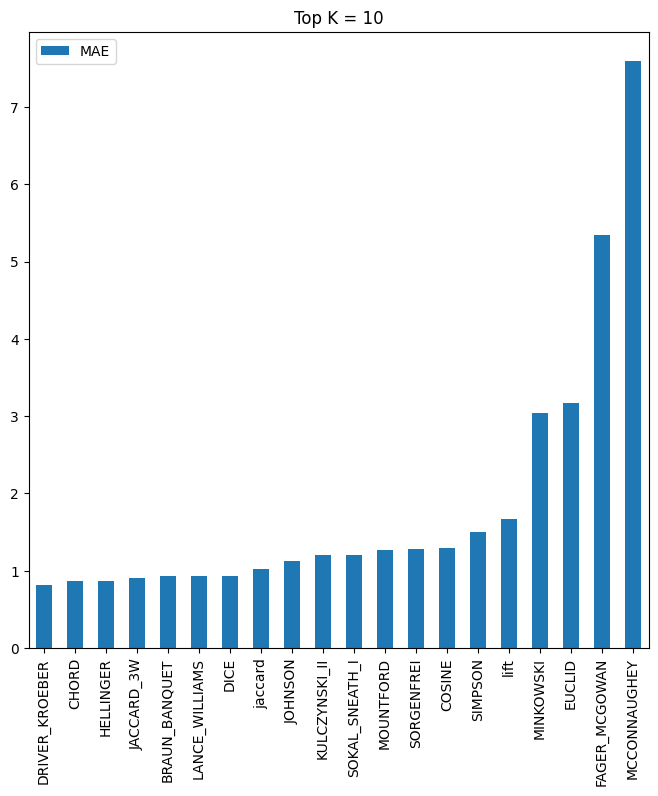

In [24]:
for i in range(len(list_top_k)):
        ax=list_dataframe[i][:split][['MAE']].sort_values(by='MAE',ascending=True).plot.bar(rot=90,figsize=(8,8))
        plt.title(f'Top K = {list_top_k[i]}')
        plt.savefig(f'Top_K__{list_top_k[i]}_MAE.png',dpi=1000)

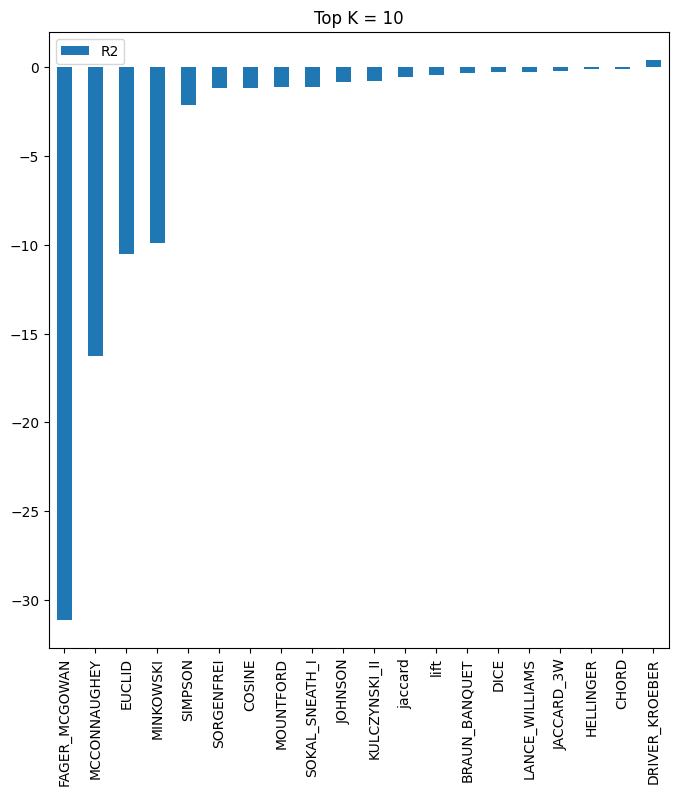

In [25]:
for i in range(len(list_top_k)):
    list_dataframe[i][:split][['R2']].sort_values(by='R2',ascending=True).plot.bar(figsize=(8,8))
    plt.title(f'Top K = {list_top_k[i]}')        
    plt.savefig(f'Top_K__{list_top_k[i]}_R2.png',dpi=1000)

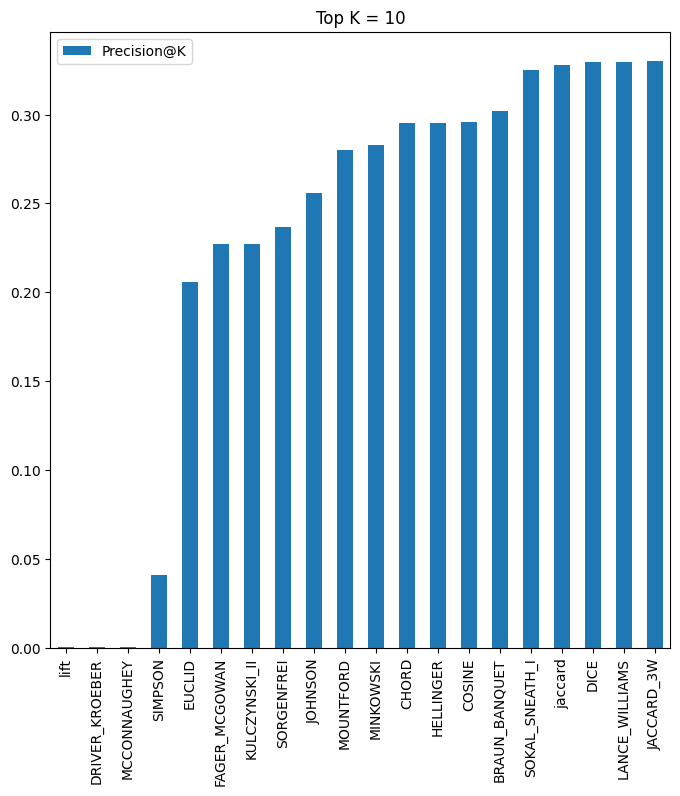

In [26]:
for i in range(len(list_top_k)):
    list_dataframe[i][:split][['Precision@K']].sort_values(by='Precision@K',ascending=True).plot.bar(figsize=(8,8))
    plt.title(f'Top K = {list_top_k[i]}')
    plt.savefig(f'Top_K__{list_top_k[i]}_Precision@K.png',dpi=1000)

# Plot the MAE, P@K, and R² for the similarity metrics with negative co-occurrences

In [27]:
 #list_dataframe[0][split:].index

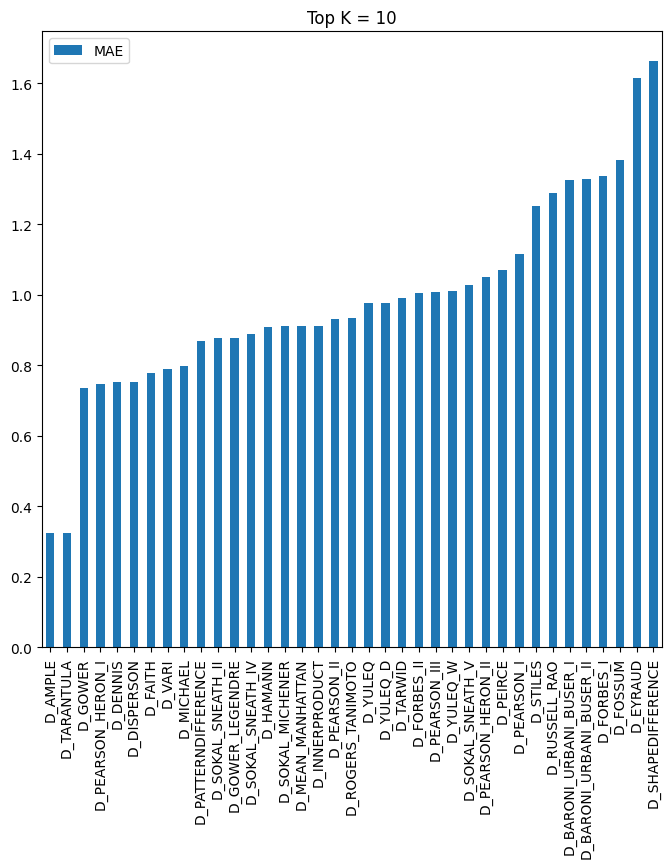

In [28]:
for i in range(len(list_top_k)):
    list_dataframe[i][split:][['MAE']].sort_values(by='MAE',ascending=True).plot.bar(figsize=(8,8))
    plt.title(f'Top K = {list_top_k[i]}')        
    plt.savefig(f'D__Top_K__{list_top_k[i]}_MAE.png',dpi=1000)

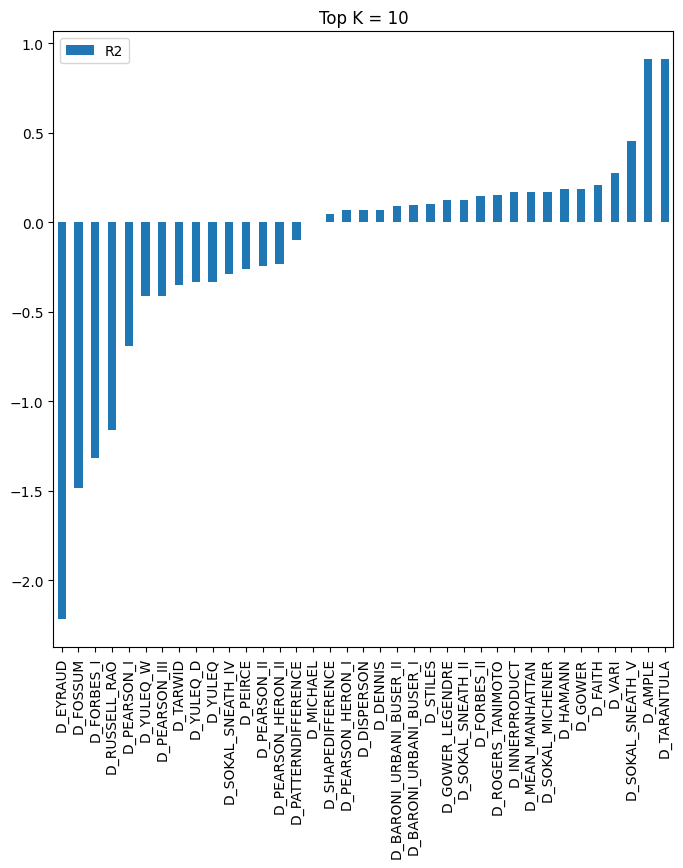

In [29]:
for i in range(len(list_top_k)):
    list_dataframe[i][split:][['R2']].sort_values(by='R2',ascending=True).plot.bar(figsize=(8,8))
    plt.title(f'Top K = {list_top_k[i]}')        
    plt.savefig(f'D__Top_K__{list_top_k[i]}_R2.png',dpi=1000)

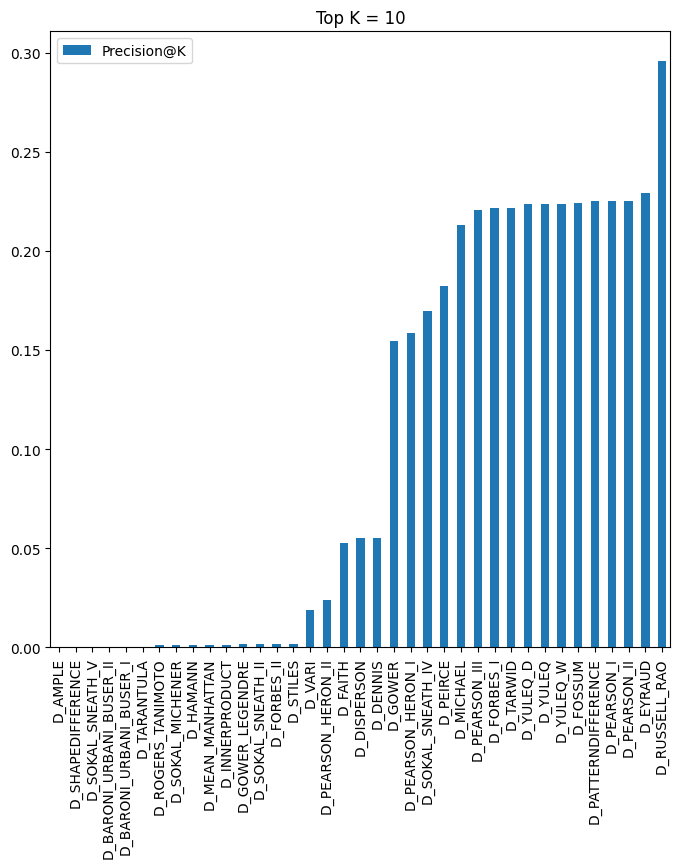

In [30]:
for i in range(len(list_top_k)):
    list_dataframe[i][split:][['Precision@K']].sort_values(by='Precision@K',ascending=True).plot.bar(figsize=(8,8))
    plt.title(f'Top K = {list_top_k[i]}')
    plt.savefig(f'D__Top_K__{list_top_k[i]}_Precision@K.png',dpi=1000)

# Plot the clustering of the similarity metrics with CAH 

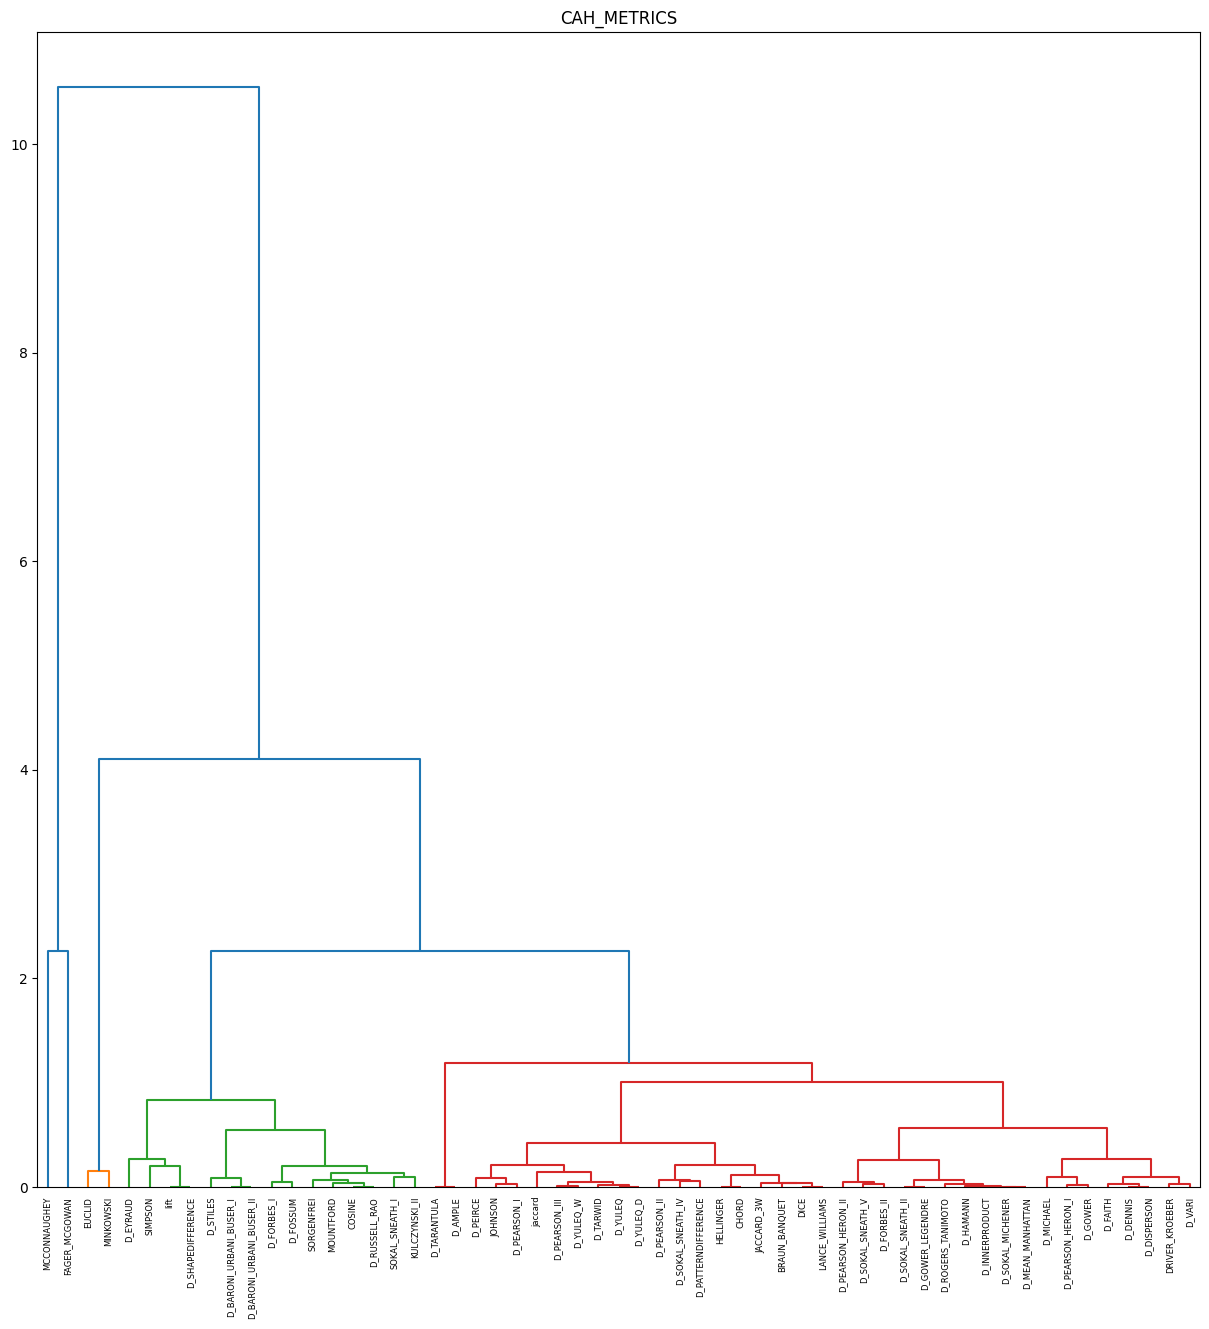

In [31]:
for i in range(len(list_top_k)):
    fig = plt.figure(figsize=(15,15))
    Z = linkage(list_dataframe[i].drop('R2',axis=1),method='ward',metric='euclidean') 
    # complete average ward single
    plt.title("CAH_METRICS")
    dendrogram(Z,labels=list_dataframe[i].index,orientation='top',color_threshold=1.5)
    plt.savefig(f'Top_{list_top_k[i]} clustring.png',dpi=1000)

In [32]:
# Save the cluster into local
#classter.to_excel("classterS.xlsx")

# Plot the correlation between the similarity metrics without and with negative co-occurrences

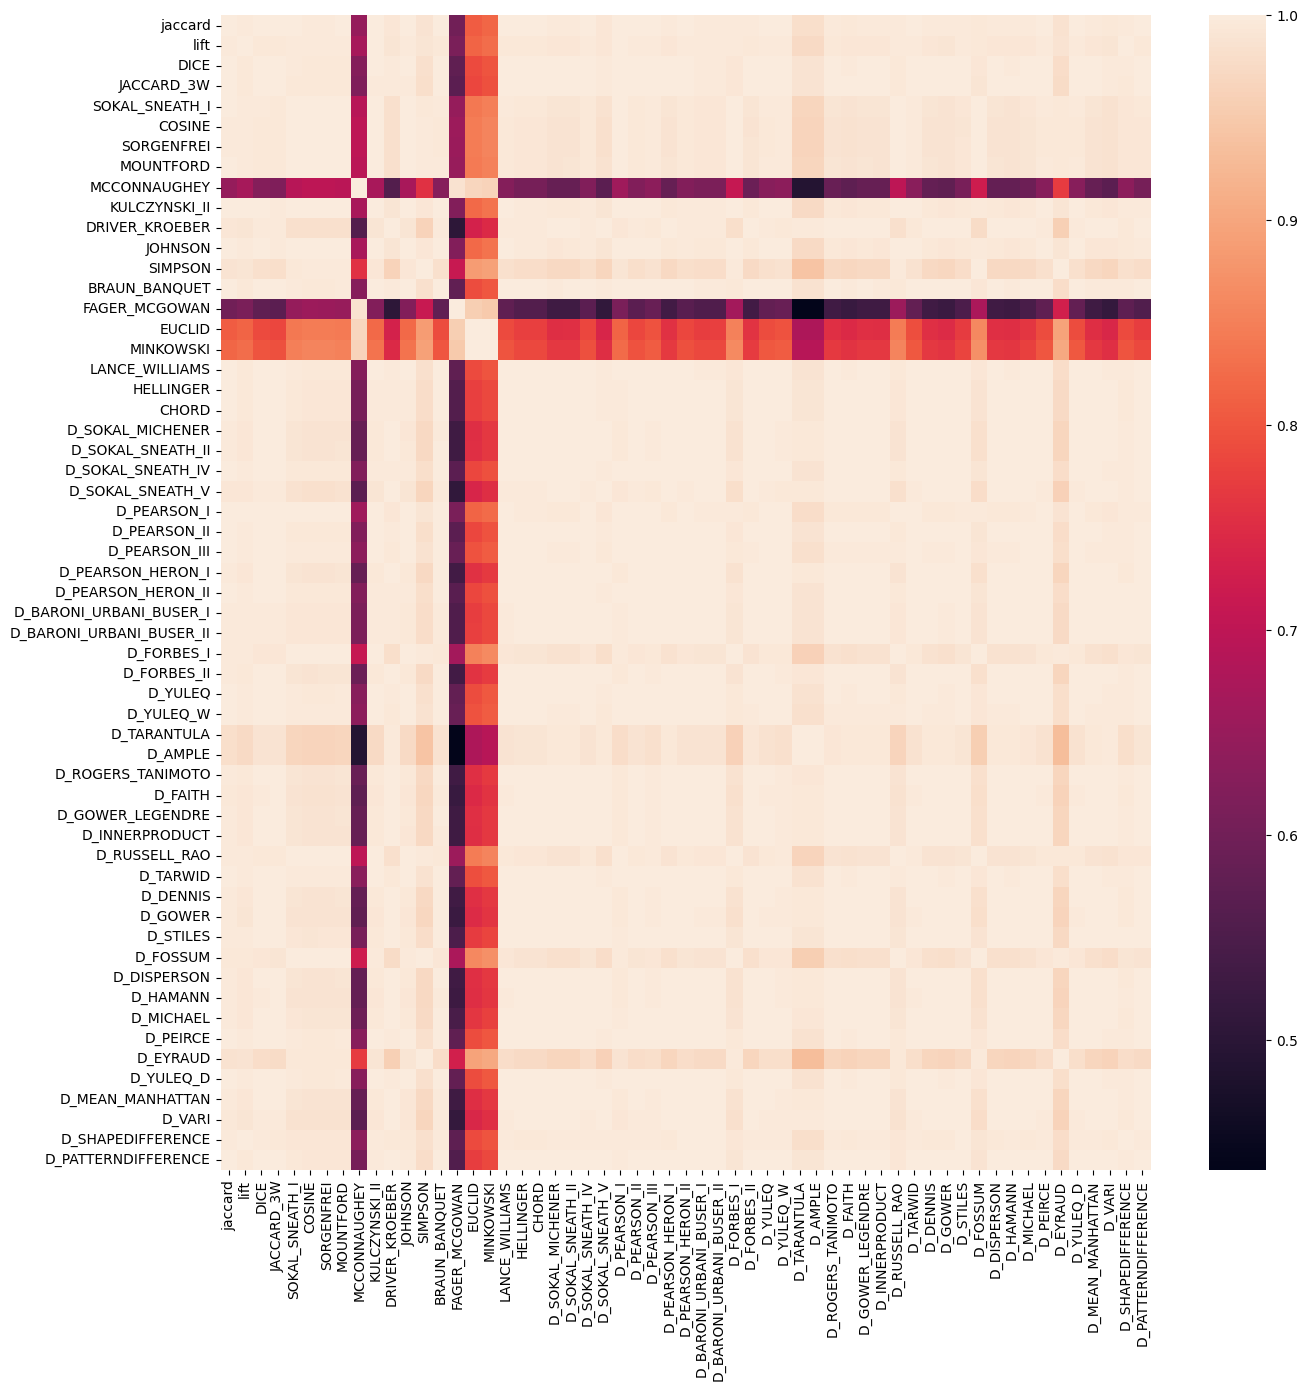

In [33]:
plt.figure(figsize=(15,15))
sns.heatmap(data=list_dataframe[0].T.corr())
plt.savefig(f'correlationbetwenn similarities.png',dpi=1000)

	The end